# Practical Example - Linear Regression 

## Importing the relevant libraries

In [121]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

sns.set()

## Load the raw data

In [123]:
# load the data from a .csv in the same folder
raw_data = pd.read_csv('1.04.+Real-life+example.csv')

# inspect the data
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


## Preprocessing

### Exploring the descriptive statistics of the variables

In [125]:
# Descriptive statistics are very useful for 'initial' exploration of the variables
# By default, only descriptives for the numerical variables are shown
# To include the categorical ones, you should specify this with an argument
raw_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [126]:
data = raw_data

## Dealing with the missing values

In [128]:
# data.isnull() -> shows a df with the information whether a data is point is null
# Since True = the data point is missing, while False = the data point is not missing
# This will give us the total number of missing values feature-wise
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

In [129]:
# Let's simply drop all missing values
# This is not always recommended, however, when we remove less than 5% (218) of the data, it is okay
data_no_mv = data.dropna(axis=0)

In [130]:
# Let's check the descriptive without the missing values
data_no_mv.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4025,4025.000000,4025,4025.000000,4025.000000,4025,4025,4025.000000,4025
unique,7,NaN,6,NaN,NaN,4,2,NaN,306
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,880,NaN,1534,NaN,NaN,1861,3654,NaN,188
mean,NaN,19552.308065,NaN,163.572174,2.764586,NaN,NaN,2006.379627,NaN
std,NaN,25815.734988,NaN,103.394703,4.935941,NaN,NaN,6.695595,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21900.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


## Exploring the PDFs

- A great step in the data exploration is to display the probability distribution function of a variable

- The PDF will show us how that variable is distributed

- This makes it very easy to spot anomalies, such as outliers

- The PDF is often the "basis" on which we decide whether we want to transform a feature

## PRICE

C:\Users\User\AppData\Local\Temp\ipykernel_24944\216991009.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_no_mv['Price'])


<Axes: xlabel='Price', ylabel='Density'>

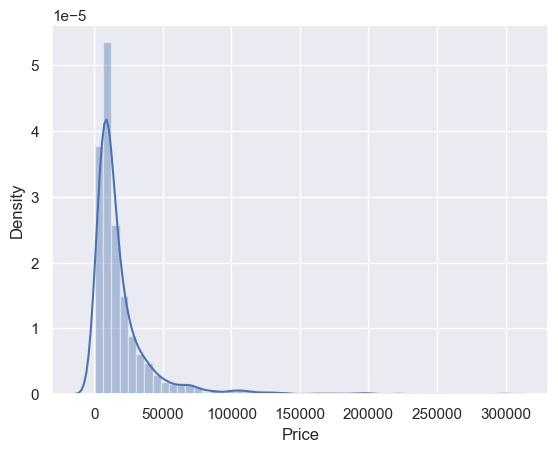

In [134]:
sns.distplot(data_no_mv['Price'])

### Dealing with outliers

Obviously there some outliers present.

Without diving too deep into the topic, we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples. Here, the outliers are situated around the higher prices (right side of the graph). Logic should also be applied. This is a dataset about used cars, therefore one can imagine how $300,000 is an excessive price.

Outliers are a great issue for OLS, thus we must deal with them in some way
It may be a useful exercise to try training a model without removing the outliers

Let's declare a variable that will be equal to the 99th percentile of the 'Price' variable

In [136]:
q = data_no_mv['Price'].quantile(0.99)

# Then we can create a new df, with the condition that all prices must be below the 99th percentile of 'Price'
data_1 = data_no_mv[data_no_mv['Price'] < q]
data_1.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3984,3984.000000,3984,3984.000000,3984.000000,3984,3984,3984.000000,3984
unique,7,NaN,6,NaN,NaN,4,2,NaN,302
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,880,NaN,1528,NaN,NaN,1853,3613,NaN,188
mean,NaN,17837.117460,NaN,165.116466,2.743770,NaN,NaN,2006.292922,NaN
std,NaN,18976.268315,NaN,102.766126,4.956057,NaN,NaN,6.672745,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6980.000000,NaN,93.000000,1.800000,NaN,NaN,2002.750000,NaN
50%,NaN,11400.000000,NaN,160.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21000.000000,NaN,230.000000,3.000000,NaN,NaN,2011.000000,NaN


C:\Users\User\AppData\Local\Temp\ipykernel_24944\858889164.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_1['Price'])


<Axes: xlabel='Price', ylabel='Density'>

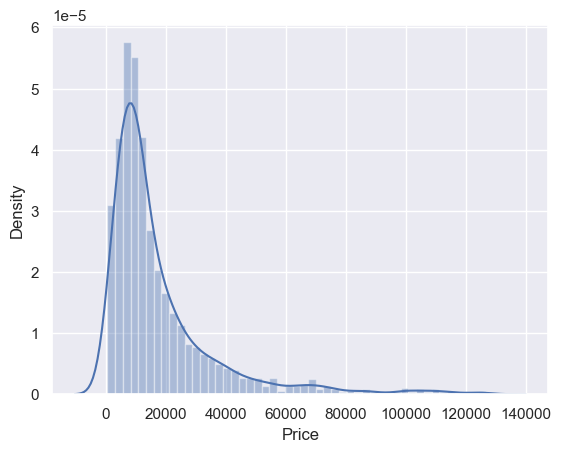

In [137]:
# We can check the PDF once again to ensure that the result is still distributed in the same way overall, howeverm there much fewer outliers
sns.distplot(data_1['Price'])

## Mileage

C:\Users\User\AppData\Local\Temp\ipykernel_24944\534165355.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_no_mv['Mileage'])


<Axes: xlabel='Mileage', ylabel='Density'>

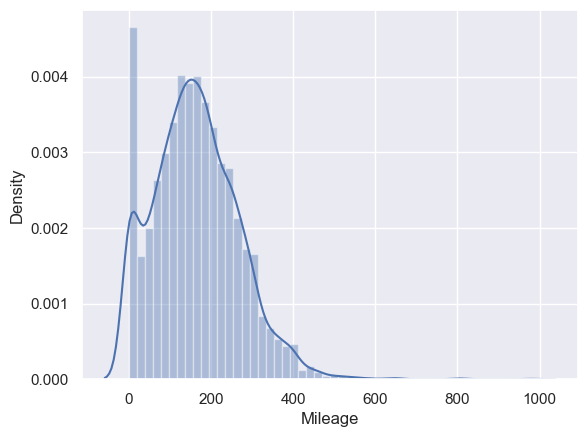

In [139]:
sns.distplot(data_no_mv['Mileage'])

In [140]:
q = data_no_mv['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage'] < q]

C:\Users\User\AppData\Local\Temp\ipykernel_24944\1037899138.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_2['Mileage'])


<Axes: xlabel='Mileage', ylabel='Density'>

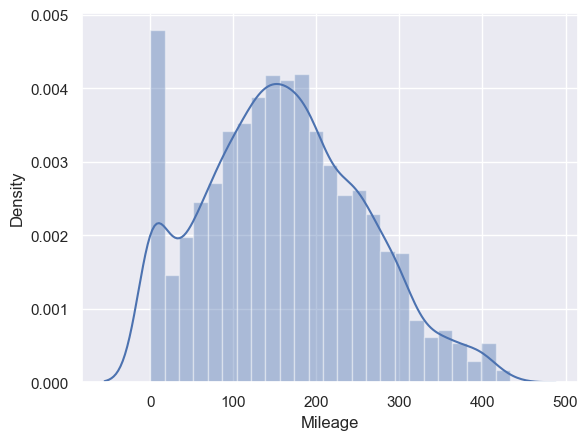

In [141]:
# plot the data_2
sns.distplot(data_2['Mileage'])

## Engine

A simple Google search can indicate the natural domain of this variable

A car engine volumnes are usually (always?) below 6.5l. This is a prime example of the fact that a domain expert (a person working in the car industry) may find it much easier to determine problems with the data than an outsider

C:\Users\User\AppData\Local\Temp\ipykernel_24944\823394628.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_no_mv['EngineV'])


<Axes: xlabel='EngineV', ylabel='Density'>

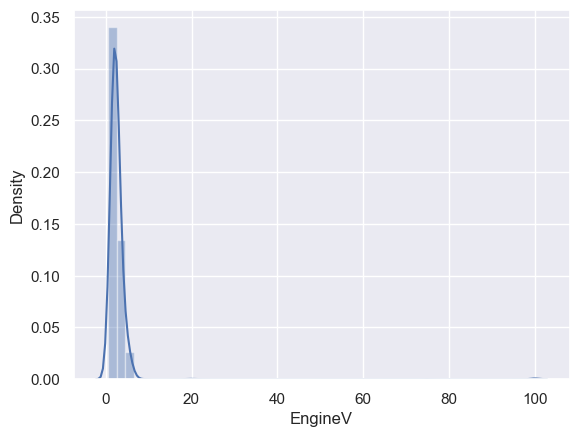

In [143]:
sns.distplot(data_no_mv['EngineV'])

In [144]:
data_3 = data_2[data_2['EngineV'] < 6.5]

C:\Users\User\AppData\Local\Temp\ipykernel_24944\1902427236.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_3['EngineV'])


<Axes: xlabel='EngineV', ylabel='Density'>

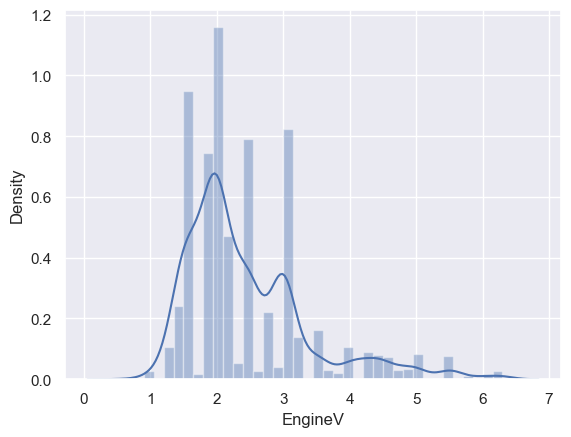

In [145]:
sns.distplot(data_3['EngineV'])

## Year

C:\Users\User\AppData\Local\Temp\ipykernel_24944\534082538.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_no_mv['Year'])


<Axes: xlabel='Year', ylabel='Density'>

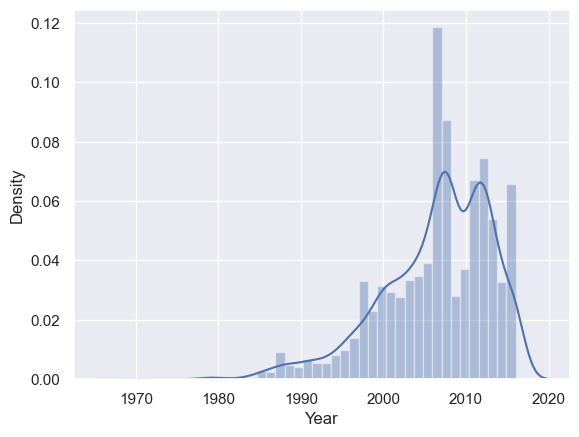

In [147]:
sns.distplot(data_no_mv['Year'])

In [148]:
q = data_3['Year'].quantile(0.01)
data_4 = data_3[data_3['Year'] > q]

C:\Users\User\AppData\Local\Temp\ipykernel_24944\4152628083.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_4['Year'])


<Axes: xlabel='Year', ylabel='Density'>

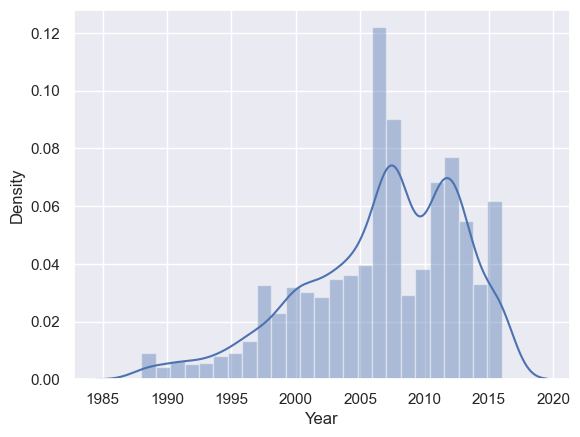

In [149]:
# Let's plot the 'Year'
sns.distplot(data_4['Year'])

When we removed observations, the original indexes are preseved.

If we remove observations with the indexes 2 and 3, the indexes will go as: 0, 1, 4, 5, 6
That's very problematic as we tend to forget about it (later you will see an example of such a problem)

Finally, once we reset the index, a new columns will be created containing the old index (just in case)
We won't be needing it, thus 'drop=True' to completely forget about it

In [151]:
data_cleaned = data_4.reset_index(drop=True)

In [152]:
# Let's see what's left
data_cleaned.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3866,3866.000000,3866,3866.000000,3866.000000,3866,3866,3866.000000,3866
unique,7,NaN,6,NaN,NaN,4,2,NaN,291
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,848,NaN,1466,NaN,NaN,1807,3504,NaN,181
mean,NaN,18197.480629,NaN,160.471547,2.450246,NaN,NaN,2006.713140,NaN
std,NaN,19087.396949,NaN,95.543697,0.949413,NaN,NaN,6.101235,NaN
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000,NaN
25%,NaN,7200.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11700.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,225.000000,3.000000,NaN,NaN,2012.000000,NaN


# Checking the OLS Assumptions

Here we decided to use some matplotlib code, without explaining it

We can simply use plt.scatter() for each of them (with our current knowledge). But since Price is the 'y' axis of the plots, it made sense to plot them side-by-side (so we can compare them)

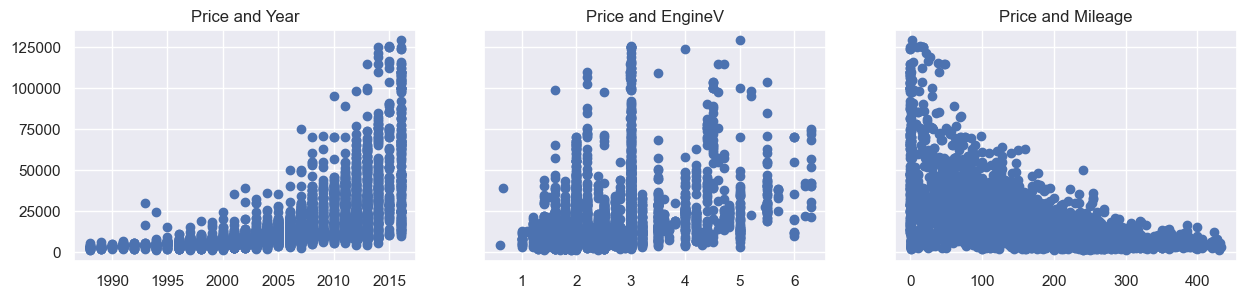

In [154]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey =True, figsize=(15,3)) #sharey -> share 'Price' as y
ax1.scatter(data_cleaned['Year'],data_cleaned['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['Price'])
ax3.set_title('Price and Mileage')

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_24944\1529477415.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_cleaned['Price'])


<Axes: xlabel='Price', ylabel='Density'>

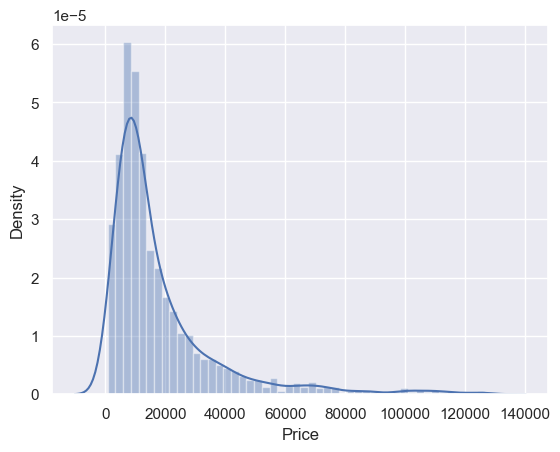

In [155]:
# From the subplots and the PDF of price, we can easily determine that 'Price' is exponentially distributed
# A good transformation in this case is a 'log transformation'
sns.distplot(data_cleaned['Price'])

## Relaxing the assumptions

In [157]:
# Let's transform the 'Price' with a log transformation
log_price = np.log(data_cleaned['Price'])

# Then, we add it to our data frame
data_cleaned['log_price'] = log_price
data_cleaned

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,9.814656
...,...,...,...,...,...,...,...,...,...,...
3861,Volkswagen,11500.0,van,163,2.5,Diesel,yes,2008,T5 (Transporter),9.350102
3862,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014,Corolla,9.792556
3863,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014,S 350,11.736069
3864,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999,535,8.779557


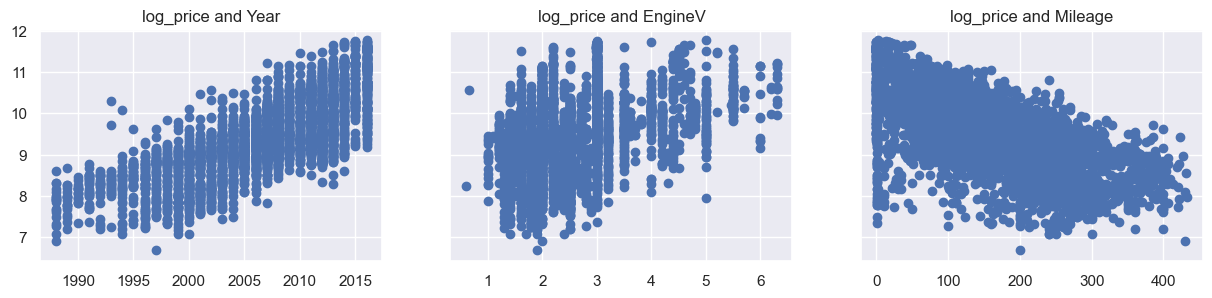

In [158]:
# Let's check the three scatters again
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
ax1.scatter(data_cleaned['Year'],data_cleaned['log_price'])
ax1.set_title('log_price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['log_price'])
ax2.set_title('log_price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['log_price'])
ax3.set_title('log_price and Mileage')

plt.show()

# The relationship shows a clear lienar relationship
# This is some good linear regression model

# Alternatively we could have transformed each of the independent variables

In [161]:
# Since we will be using the log price variable, we can drop the old 'Price' one
data_cleaned = data_cleaned.drop(['Price'], axis = 1)
data_cleaned

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_price
0,BMW,sedan,277,2.0,Petrol,yes,1991,320,8.342840
1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,8.974618
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,9.495519
3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,10.043249
4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,9.814656
...,...,...,...,...,...,...,...,...,...
3861,Volkswagen,van,163,2.5,Diesel,yes,2008,T5 (Transporter),9.350102
3862,Toyota,sedan,35,1.6,Petrol,yes,2014,Corolla,9.792556
3863,Mercedes-Benz,sedan,9,3.0,Diesel,yes,2014,S 350,11.736069
3864,BMW,sedan,1,3.5,Petrol,yes,1999,535,8.779557


## Multicollinearity

In [167]:
# Let's quickly see the columns of our data frame
data_cleaned.columns.values

array(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'Model', 'log_price'], dtype=object)

- sklearn does not have a built-in way to check for multicollinearity

- one of the main reasons is that this is an issue well covered in statistical frameworks and not in ML ones

- surely it is an issue nonetheless, thus we will try to deal with it

In [186]:
# import package module
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To make this easy as possible to use, we declare a variable where we put all features where we want to check for multicollinearity.
# Since our categorical data is not yet preprocessed, we will only take the numerical ones
variables = data_cleaned[['Mileage', 'Year', 'EngineV']]

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

# Finally, include thename so it is easier to explore the result
vif['Features'] = variables.columns

In [188]:
# Let's explore the results
vif

,VIF,Features
0,3.794319,Mileage
1,10.360888,Year
2,7.660317,EngineV


In [190]:
# Since 'Year' has the highest VIF, we will remove it from the model
# This will drive the VIF of other variables down!!!
# So even in EngineV seems with a high VIF, too, once 'Year' is gone that will no longer be the case
data_no_multicollinearity = data_cleaned.drop(['Year'], axis=1)

## Create dummy variables

- To include the categorical data in the regression, let's create dummies.
- There is a very convenient method called: 'get_dummies' which does that seemlessly
- It is extremely important that we drop of the dummies, alternatively we will introduce multicollinearity

In [194]:
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first=True)

In [196]:
# Explore the result
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,...,Model_Vito,Model_X1,Model_X3,Model_X5,Model_X5 M,Model_X6,Model_X6 M,Model_Yaris,Model_Z3,Model_Z4
0,277,2.0,8.342840,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,427,2.9,8.974618,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,358,5.0,9.495519,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,240,4.2,10.043249,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,120,2.0,9.814656,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [198]:
# To make our data frame more organized, we prefer to place the dependent variable in the beginning of the df
# Since each problem is different, that must be done manually
# We can display all possible features and then choose the desired order
data_with_dummies.columns.values

array(['Mileage', 'EngineV', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes',
       'Model_100', 'Model_11', 'Model_116', 'Model_118', 'Model_120',
       'Model_19', 'Model_190', 'Model_200', 'Model_210', 'Model_220',
       'Model_230', 'Model_25', 'Model_250', 'Model_300', 'Model_316',
       'Model_318', 'Model_320', 'Model_323', 'Model_325', 'Model_328',
       'Model_330', 'Model_335', 'Model_4 Series Gran Coupe', 'Model_428',
       'Model_4Runner', 'Model_5 Series', 'Model_5 Series GT',
       'Model_520', 'Model_523', 'Model_524', 'Model_525', 'Model_528',
       'Model_530', 'Model_535', 'Model_540', 'Model_545', 'Model_550',
       'Model_6 Series Gran Coupe', 'Model_630', 'Model_640', 'Model_645',
       'Model_650', 'Model_73

In [202]:
# To make the code a bit more parametrized, let's declare a new variable that will contain the preferred order
# If you want a different order, just specify it here
# Conventionally, the most intuitive order: dependent variable, independen numerical variables, dummies
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes',
       'Model_100', 'Model_11', 'Model_116', 'Model_118', 'Model_120',
       'Model_19', 'Model_190', 'Model_200', 'Model_210', 'Model_220',
       'Model_230', 'Model_25', 'Model_250', 'Model_300', 'Model_316',
       'Model_318', 'Model_320', 'Model_323', 'Model_325', 'Model_328',
       'Model_330', 'Model_335', 'Model_4 Series Gran Coupe', 'Model_428',
       'Model_4Runner', 'Model_5 Series', 'Model_5 Series GT',
       'Model_520', 'Model_523', 'Model_524', 'Model_525', 'Model_528',
       'Model_530', 'Model_535', 'Model_540', 'Model_545', 'Model_550',
       'Model_6 Series Gran Coupe', 'Model_630', 'Model_640', 'Model_645',
       'Model_650', 'Model_730', 'Model_735', 'Model_740', 'Model_745',
       'Model_750', 'Model_760', 'Model_80', 'Model_9', 'Model_90',
       'Model_A 140', 'Model_A 150', 'Model_A 170', 'Model_A 180',
       'Model_A1', 'Model_A3', 'Model_A4', 'Model_A4 Allroad', 'Model_A5',
       'Model_A6', 'Model_A6 Allroad', 'Model_A7', 'Model_A8',
       'Model_ASX', 'Model_Amarok', 'Model_Auris', 'Model_Avalon',
       'Model_Avensis', 'Model_Aygo', 'Model_B 170', 'Model_B 180',
       'Model_B 200', 'Model_Beetle', 'Model_Bora', 'Model_C-Class',
       'Model_CL 180', 'Model_CL 500', 'Model_CL 55 AMG', 'Model_CL 550',
       'Model_CL 63 AMG', 'Model_CLA 200', 'Model_CLA 220',
       'Model_CLA-Class', 'Model_CLC 180', 'Model_CLC 200',
       'Model_CLK 200', 'Model_CLK 220', 'Model_CLK 230', 'Model_CLK 240',
       'Model_CLK 280', 'Model_CLK 320', 'Model_CLK 430', 'Model_CLS 350',
       'Model_CLS 400', 'Model_CLS 500', 'Model_CLS 63 AMG',
       'Model_Caddy', 'Model_Camry', 'Model_Captur', 'Model_Caravelle',
       'Model_Carina', 'Model_Carisma', 'Model_Celica', 'Model_Clio',
       'Model_Colt', 'Model_Corolla', 'Model_Corolla Verso',
       'Model_Cross Touran', 'Model_Dokker', 'Model_Duster',
       'Model_E-Class', 'Model_Eclipse', 'Model_Eos', 'Model_Espace',
       'Model_FJ Cruiser', 'Model_Fluence', 'Model_Fortuner',
       'Model_G 320', 'Model_G 350', 'Model_G 500', 'Model_G 55 AMG',
       'Model_G 63 AMG', 'Model_GL 320', 'Model_GL 350', 'Model_GL 420',
       'Model_GL 450', 'Model_GL 500', 'Model_GL 550', 'Model_GLC-Class',
       'Model_GLE-Class', 'Model_GLK 220', 'Model_GLK 300',
       'Model_GLS 350', 'Model_GLS 400', 'Model_Galant', 'Model_Golf GTI',
       'Model_Golf II', 'Model_Golf III', 'Model_Golf IV',
       'Model_Golf Plus', 'Model_Golf V', 'Model_Golf VI',
       'Model_Golf VII', 'Model_Golf Variant', 'Model_Grand Scenic',
       'Model_Grandis', 'Model_Hiace', 'Model_Highlander', 'Model_Hilux',
       'Model_I3', 'Model_IQ', 'Model_Jetta', 'Model_Kangoo',
       'Model_Koleos', 'Model_L 200', 'Model_LT', 'Model_Laguna',
       'Model_Lancer', 'Model_Lancer Evolution', 'Model_Lancer X',
       'Model_Lancer X Sportback', 'Model_Land Cruiser 100',
       'Model_Land Cruiser 105', 'Model_Land Cruiser 200',
       'Model_Land Cruiser 76', 'Model_Land Cruiser 80',
       'Model_Land Cruiser Prado', 'Model_Latitude', 'Model_Logan',
       'Model_Lupo', 'Model_M5', 'Model_M6', 'Model_MB', 'Model_ML 250',
       'Model_ML 270', 'Model_ML 280', 'Model_ML 320', 'Model_ML 350',
       'Model_ML 400', 'Model_ML 430', 'Model_ML 500', 'Model_ML 550',
       'Model_ML 63 AMG', 'Model_Master', 'Model_Matrix', 'Model_Megane',
       'Model_Modus', 'Model_Multivan', 'Model_New Beetle',
       'Model_Outlander', 'Model_Outlander XL', 'Model_Pajero',
       'Model_Pajero Pinin', 'Model_Pajero Sport', 'Model_Pajero Wagon',
       'Model_Passat B3', 'Model_Passat B4', 'Model_Passat B5',
       'Model_Passat B6', 'Model_Passat B7', 'Model_Passat B8',
       'Model_Passat CC', 'Model_Phaeton', 'Model_Pointer', 'Model_Polo',
       'Model_Previa', 'Model_Prius', 'Model_Q3', 'Model_Q5', 'Model_Q7',
       'Model_R 320', 'Model_R8', 'Model_Rav 4', 'Model_S 140',
       'Model_S 250', 'Model_S 300', 'Model_S 320', 'Model_S 350',
       'Model_S 400', 'Model_S 430', 'Model_S 500', 'Model_S 550',
       'Model_S 600', 'Model_S 63 AMG', 'Model_S 65 AMG', 'Model_S4',
       'Model_S5', 'Model_S8', 'Model_SL 500 (550)', 'Model_SL 55 AMG',
       'Model_SLK 200', 'Model_SLK 350', 'Model_Sandero',
       'Model_Sandero StepWay', 'Model_Scenic', 'Model_Scion',
       'Model_Scirocco', 'Model_Sequoia', 'Model_Sharan', 'Model_Sienna',
       'Model_Smart', 'Model_Space Star', 'Model_Space Wagon',
       'Model_Sprinter 208', 'Model_Sprinter 210', 'Model_Sprinter 211',
       'Model_Sprinter 212', 'Model_Sprinter 213', 'Model_Sprinter 311',
       'Model_Sprinter 312', 'Model_Sprinter 313', 'Model_Sprinter 315',
       'Model_Sprinter 316', 'Model_Sprinter 318', 'Model_Sprinter 319',
       'Model_Symbol', 'Model_Syncro', 'Model_T3 (Transporter)',
       'Model_T4 (Transporter)', 'Model_T4 (Transporter) ',
       'Model_T5 (Transporter)', 'Model_T5 (Transporter) ',
       'Model_T6 (Transporter)', 'Model_T6 (Transporter) ', 'Model_TT',
       'Model_Tacoma', 'Model_Tiguan', 'Model_Touareg', 'Model_Touran',
       'Model_Trafic', 'Model_Tundra', 'Model_Up', 'Model_V 250',
       'Model_Vaneo', 'Model_Vento', 'Model_Venza', 'Model_Viano',
       'Model_Virage', 'Model_Vista', 'Model_Vito', 'Model_X1',
       'Model_X3', 'Model_X5', 'Model_X5 M', 'Model_X6', 'Model_X6 M',
       'Model_Yaris', 'Model_Z3', 'Model_Z4']

In [204]:
# To implement the reordering, we will create a new df, which is equal to the old one but with the new order of features
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,...,Model_Vito,Model_X1,Model_X3,Model_X5,Model_X5 M,Model_X6,Model_X6 M,Model_Yaris,Model_Z3,Model_Z4
0,8.342840,277,2.0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,8.974618,427,2.9,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,9.495519,358,5.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,10.043249,240,4.2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,9.814656,120,2.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


## Linear Regression Model

### Declare the inputs and the targets

In [210]:
# The target(s) (dependent variable) is 'log_price'
targets = data_preprocessed['log_price']

# The inputs are everything BUT the dependent variable, so we can simply drop it
inputs = data_preprocessed.drop(['log_price'], axis = 1)

### Scale the data

In [213]:
# Import the scaling module
from sklearn.preprocessing import StandardScaler

# Create the scalar object
scaler = StandardScaler()

# Fit the inputs(calculate the mean and the standard deviation feature-wise)
scaler.fit(inputs)

StandardScaler()

In [219]:
# Scale the features and store them in a new variable (the actual scaling procedure)
inputs_scaled = scaler.transform(inputs)

## Train Test Split

In [222]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
# To have the same split, use random_state = 365
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

***

### Create the regression

In [225]:
# Create a linear regression object
reg = LinearRegression()

# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train, y_train)

LinearRegression()

In [227]:
# Let's check the outputs of the regression
# Store the in y_hat as this is the 'theoretical' name for prediction
y_hat = reg.predict(x_train)

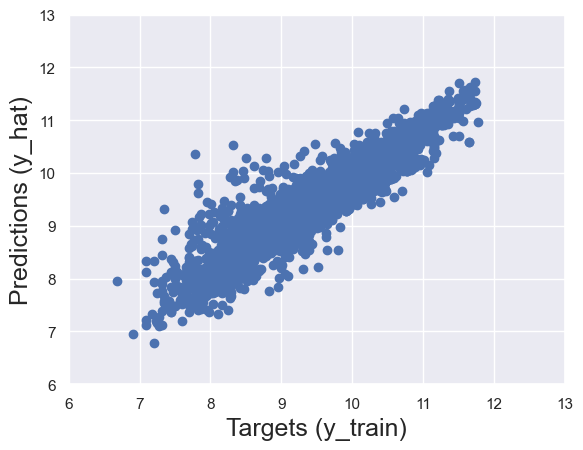

In [229]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)

plt.xlabel('Targets (y_train)', size = 18)
plt.ylabel('Predictions (y_hat)', size = 18)

# We want the x-axis and the y-axis to be the same
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_24944\300010958.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train - y_hat)


Text(0.5, 1.0, 'Residual PDF')

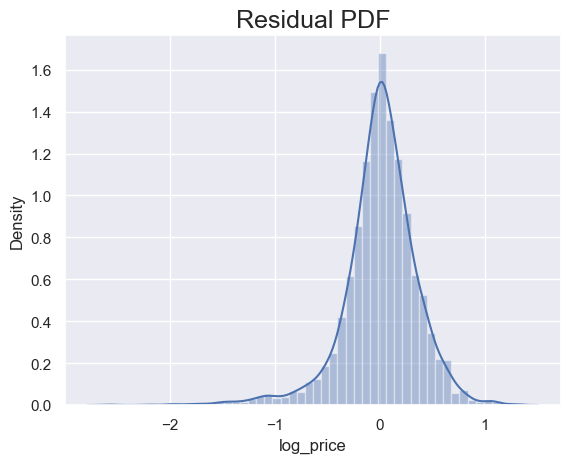

In [235]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check the for anomalies
sns.distplot(y_train - y_hat)

plt.title('Residual PDF', size = 18)

# In the best case scenario this plot should be normally distributed
# In our case we notice that there are many negative residuals (far away from the mean)
# Given the definition of the residuals (y_train - y_hat), negative values imply that y_hat (predictions) are much higher than y_train (the targets)
# This is food for thought to improve our model

In [239]:
# Find the R-squared of the model
reg.score(x_train, y_train)

# NOTE: this is NOT the adjusted R-squared
# in other words... find the Adjusted R-squared to have the appropriate measure

0.8375204093352098

### Adjusted $R^{2}$

In [242]:
# Get the shape of x, to facilitate the creation of the Adjusted R^2 metric
x_train.shape

(3092, 307)

In [246]:
# If we want to find the adjusted r2, we can do so by knowing the r2, the # of observations, the # features
r2 = reg.score(x_train, y_train)

# No.of observations is the shape along axis 0
n = x_train.shape[0]

# No. of features (predictors, p) is the shape along the axis 1
p = x_train.shape[1]

# Use the formula
adjusted_r2 = 1 - (1-r2) * (n-1)/(n-p-1)
adjusted_r2

0.8196032993014128

### Finding weights and bias

## Testing